In [1]:
import pandas as pd
import numpy as np
from math import *
from sklearn import model_selection, metrics, dummy

import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Chargement des données

In [3]:
import pickle

with open("./data/pickle", 'rb') as f:
    data_X, data_Y = pickle.load(f)

In [4]:
avec_etoile = 0

In [5]:
# 0 pour les données sans star, 1 pour energystar
data_X = data_X[avec_etoile]
data_Y = data_Y[avec_etoile]

## Liste des colonnes utilisables

In [6]:
col_num = list(data_X.select_dtypes(include=['float', 'int', 'uint8']).columns)

# Prédiction simple

Pas de sélection, juste pour observer différents algos en CV (dont leur stabilité)

In [7]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, MultiTaskLassoCV

In [8]:
def launch_kfold(model, X, y, splits=8, silence=False):
    kf = KFold(n_splits=splits)
    score_final = {'R2':0, 'RMSE':0, 'MAE':0}
    
    donnees_min = {'R2':1, 'iloc':None, 'pred':None}
    donnees_max = {'R2':-1, 'iloc':None, 'pred':None}

    for train, test in kf.split(X):
        # Entraînement
        model.fit(X.iloc[train], y.iloc[train])

        # Prédiction sur le jeu de test
        y_pred = model.predict(X.iloc[test])

        y_test = y.iloc[test]

        # Evaluate
        score = metrics.r2_score(y_test, y_pred)
        if not silence:
            print('R2 : ', score)
        score_final['R2'] += abs(score)
        
        if score < donnees_min['R2']:
            donnees_min['R2'] = score
            donnees_min['iloc'] = test.copy()
            donnees_min['pred'] = y_pred.copy()
        
        if score > donnees_max['R2']:
            donnees_max['R2'] = score
            donnees_max['iloc'] = test.copy()
            donnees_max['pred'] = y_pred.copy()

        score = metrics.mean_squared_error(y_test, y_pred, squared=True)
        score_final['RMSE'] += score

        score = metrics.mean_absolute_error(y_test.applymap(lambda x:max(0, x)), y_pred)
        score_final['MAE'] += score

    if not silence:
        for k, score in score_final.items():
            print('Score {} final : {}'.format(k, score/kf.get_n_splits()))
    
    return donnees_max, donnees_min

### Partie pour detecter les outliers réguliers
aka les lignes qui ne sont jamais bien prédites

In [9]:
def get_outliers(data_test, data_pred, outliers={}, step=0, limit=20):
    data_pred = pd.Series(data_pred, index=data_test.index).rename('Pred')

    compare_result = pd.concat([data_test.rename('Test'), data_pred], axis=1)
    compare_result['Diff'] = (compare_result['Test'] - compare_result['Pred']).abs()
    compare_result = compare_result.sort_values(by='Diff', ascending=False)
    
    for i in compare_result.head(limit).index:
        if i not in outliers:
            outliers[i] = 1-step
        else:
            outliers[i] += 1-step
    
    return outliers

In [10]:
outliers = {}

In [11]:
'''
for _ in range(50):
    idx = np.random.permutation(data_X.index)
    data_X = data_X.reindex(idx)
    data_Y = data_Y.reindex(idx)

    regr = XGBRegressor() #RandomForestRegressor(max_depth=50), XGBRegressor(), MultiTaskLassoCV(cv=5)
    donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y['Energy_Y'], silence=True)
    print(donnees_min['R2'])
    if donnees_min['R2'] < 0.6 :
        outliers = get_outliers(data_Y.iloc[donnees_min['iloc'], 0], np.transpose(donnees_min['pred'])[0], outliers, step=donnees_min['R2'], limit=10)
'''

"\nfor _ in range(50):\n    idx = np.random.permutation(data_X.index)\n    data_X = data_X.reindex(idx)\n    data_Y = data_Y.reindex(idx)\n\n    regr = XGBRegressor() #RandomForestRegressor(max_depth=50), XGBRegressor(), MultiTaskLassoCV(cv=5)\n    donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y['Energy_Y'], silence=True)\n    print(donnees_min['R2'])\n    if donnees_min['R2'] < 0.6 :\n        outliers = get_outliers(data_Y.iloc[donnees_min['iloc'], 0], np.transpose(donnees_min['pred'])[0], outliers, step=donnees_min['R2'], limit=10)\n"

In [12]:
# pd.DataFrame(outliers.items()).sort_values(by=1, ascending=False).head(20)

Suppression de ces valeurs

In [13]:
for i in []:#[601, 1817, 1000, 1027, 3206, 2896, 3171, 3373, 550, 426]:
    data_X = data_X.drop(index=i)
    data_Y = data_Y.drop(index=i)

## Test de différents regressors

In [14]:
print('KFold avec DummyRegressor :')
dum = dummy.DummyRegressor(strategy='median')
launch_kfold(dum, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec Lasso :')
regr = MultiTaskLassoCV(cv=5, max_iter=3000)
launch_kfold(regr, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec XGBoost :')
xgbreg = XGBRegressor()
launch_kfold(xgbreg, data_X[col_num], data_Y)

print('\n'*3, 'KFold avec RandomForest :')
regr = RandomForestRegressor(max_depth=50)
donnees_max, donnees_min = launch_kfold(regr, data_X[col_num], data_Y)

KFold avec DummyRegressor :
R2 :  -0.0006128941509783159
R2 :  -0.019576967829067482
R2 :  -0.00044172858224855727
R2 :  -0.030166336081376754
R2 :  -0.013781322035158805
R2 :  -0.00429418259733072
R2 :  -0.0005796716117405509
R2 :  -0.014237429431106174
Score R2 final : 0.01046131653987592
Score RMSE final : 1.8725389540195465
Score MAE final : 1.080284839254248



 KFold avec Lasso :
R2 :  0.6743861197241414
R2 :  0.7173245376452946
R2 :  0.7491481168647921
R2 :  0.6869602261589942
R2 :  0.7067585267872889
R2 :  0.7118820536301983
R2 :  0.678229227408898
R2 :  0.6805685487609584
Score R2 final : 0.7006571696225707
Score RMSE final : 0.5576897783612398
Score MAE final : 0.5705904708584626



 KFold avec XGBoost :
R2 :  0.6516180443281249
R2 :  0.7176461851505581
R2 :  0.7441493097982002
R2 :  0.7197370280231168
R2 :  0.7284277644104472
R2 :  0.7008788233185604
R2 :  0.6041453763404651
R2 :  0.6984267474127823
Score R2 final : 0.6956286598477819
Score RMSE final : 0.5658315867185593
Sc

## Affichage des features importance

In [15]:
def get_features_importance(model, X, y, plot=False):
    model.fit(X, y)
    #importance = model.feature_importances_
    importance = abs(model.coef_)

    list_col = X.columns.to_list()
    list_features = []
    for i, v in pd.Series(importance).sort_values(ascending=True).items():
        list_features.append([list_col[i],v])
    
    list_features = pd.DataFrame(list_features, columns=['Nom', 'Value'])
    
    if plot:
        list_features.head(15).plot.barh(x='Nom', y='Value', figsize=(7,7))
    
    return list_features

,Nom,Value
0,Type_Autre,2.888344e-15
1,Type_Bank branch,5.844473e-04
2,Type_Other - services,7.713915e-04
3,Type_Social/meeting hall,2.243596e-03
4,Type_Other - entertainment/public assembly,4.587230e-03
5,Type_Residence hall,6.637756e-03
6,Type_University,8.197317e-03
7,SeaProximity,1.181535e-02
8,Longitude,1.527554e-02
9,Latitude,1.589108e-02


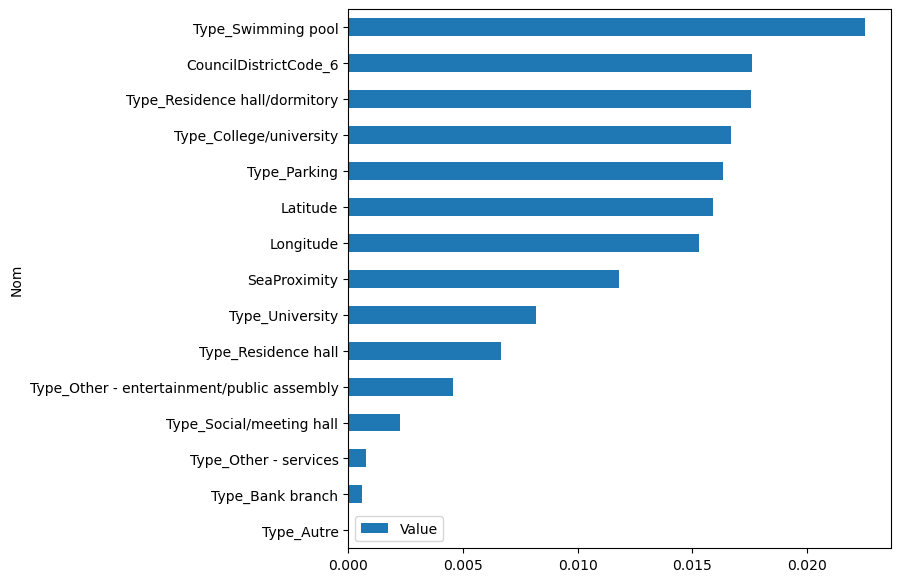

In [16]:
model = RandomForestRegressor(max_depth=30)
model = XGBRegressor()
model = BayesianRidge(alpha_init=1, lambda_init=0.1)

get_features_importance(model, data_X[col_num], data_Y['Energy_Y'], True)

# GridSearch sur plusieurs algos

In [17]:
TARGET = 'Energy_Y' #'Energy_Y', 'CO2_Y'

In [18]:
from sklearn.model_selection import GridSearchCV
import time

list_models = []

def grid_search_cv_models(X, y, models, params):
    global list_models
    best_score = 0
    best_model = None
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33)

    for model, model_params in zip(models, params):
        gs = GridSearchCV(model, model_params, cv=5, error_score='raise', refit='r2', scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
        
        # Entraîner le modèle sur les données X et y
        gs.fit(X_train, y_train)
        
        print("\n"*5, str(gs.best_estimator_), '\n')
        
        nom_estimator = str(gs.best_estimator_)
        
        list_models.append({"name":nom_estimator[:nom_estimator.index('(')], "clf":gs.best_estimator_})
        
        tab_cv_result = pd.DataFrame(gs.cv_results_)
        
        print(tab_cv_result[['mean_fit_time', 'mean_score_time', 'mean_test_r2']]) # 'params', 
        
        tab_cv_result = tab_cv_result.loc[tab_cv_result['rank_test_r2']==1]
        
        print("Temps d'entrainement : ", tab_cv_result['mean_fit_time'].to_list()[0])
        print("Temps de prédiction : ", tab_cv_result['mean_score_time'].to_list()[0])
        
        for n, m in [('R2', 'r2'), ('RMSE', 'neg_root_mean_squared_error'), ('MAE', 'neg_mean_absolute_error')]:
            mean = tab_cv_result['mean_test_'+m].to_list()[0]
            std = tab_cv_result['std_test_'+m].to_list()[0]
            
            if n!='R2':
                mean = -mean
                
            print("Score {} : {:.4f} Deviation : {:.4f}".format(n, mean, std))
        
        
        #print(tab_cv_result.columns)
        print('\nTest sur les données restantes :')
        
        start_time = time.time()
        trained_estimator = gs.best_estimator_.fit(X_train, y_train)
        print("Temps d'entrainement : ", time.time() - start_time)
        
        start_time = time.time()
        y_pred = trained_estimator.predict(X_test)
        print("Temps de prédiction : ", time.time() - start_time)
        
        for n, m in [('R2', metrics.r2_score),
                     ('RMSE', metrics.mean_squared_error),
                     ('MAE', metrics.mean_absolute_error)]:
            score = m(y_test, np.abs(y_pred))
            
            if n=='RMSE':
                score = sqrt(score)
            
            print("Score {} : {:.4f}".format(n, score))
        
        # Si le meilleur score de ce modèle est supérieur au meilleur score actuel, le mettre à jour
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_model = gs.best_estimator_
    # Renvoyer le meilleur modèle
    return best_model

In [19]:
# Une liste de modèles
models = [dummy.DummyRegressor(), KNeighborsRegressor(), LassoCV(), RandomForestRegressor(), Ridge(), LinearRegression(), Lasso(), BayesianRidge(), XGBRegressor()]
# Une liste de paramètres pour les modèles correspondants
params = [{'strategy':['mean', 'median']},
          {'n_neighbors':[5, 10, 15, 30], 'weights':['distance']},
          {'cv':[2, 3, 4, 5, 6, 8], 'max_iter':[4000]},
          {"max_depth": [3, 5, 10, 20, 30, 50, 75, 100]},
          {"alpha": np.arange(0.1, 0.9, 0.01)},
          {},
          {"alpha": np.arange(0.1, 0.9, 0.01)},
          {'alpha_init':[1, 1.4, 1.9],
           'lambda_init': [1e-1, 1e-3, 1e-5]},
          {"learning_rate": [0.10, 0.15],
            "max_depth": [3, 5],
            "min_child_weight": [2, 3, 4],
            "gamma":[0.0, 0.05],
            "colsample_bytree":[0.3, 0.4]}]


best_model = grid_search_cv_models(data_X[col_num], data_Y[TARGET], models, params)
print("Le meilleur modèle est:", best_model)






 DummyRegressor() 

   mean_fit_time  mean_score_time  mean_test_r2
0       0.000000         0.001301     -0.002290
1       0.003132         0.000000     -0.014309
Temps d'entrainement :  0.0
Temps de prédiction :  0.0013010501861572266
Score R2 : -0.0023 Deviation : 0.0019
Score RMSE : 1.2756 Deviation : 0.0963
Score MAE : 1.0346 Deviation : 0.0806

Test sur les données restantes :
Temps d'entrainement :  0.0
Temps de prédiction :  0.0
Score R2 : -0.0087
Score RMSE : 1.3132
Score MAE : 1.0242





 KNeighborsRegressor(n_neighbors=15, weights='distance') 

   mean_fit_time  mean_score_time  mean_test_r2
0       0.003115         0.100440      0.631617
1       0.006426         0.086261      0.633259
2       0.004816         0.089079      0.636550
3       0.003212         0.091071      0.630282
Temps d'entrainement :  0.0048160552978515625
Temps de prédiction :  0.08907923698425294
Score R2 : 0.6365 Deviation : 0.0399
Score RMSE : 0.7667 Deviation : 0.0671
Score MAE : 0.5792 Deviatio

## Analyse et comparaison des algos
avec les meilleurs hypermarametres sélectionnés

In [20]:
def setup_plot():
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"]  = 15 

In [21]:
from sklearn.ensemble import VotingRegressor

tmp_reg = []
for e in list_models:
    if e['name'] in ['BayesianRidge', 'LassoCV', 'XGBRegressor']:
        tmp_reg.append((e['name'], e['clf']))

reg = VotingRegressor(estimators=tmp_reg)
list_models.append({'name':'Voting-Bay-Lasso-XGB', 'clf':reg})

In [22]:
#list_models.pop(-1)
list_models.pop(5)

{'name': 'LinearRegression', 'clf': LinearRegression()}

name
DummyRegressor           0.000000
KNeighborsRegressor      0.634324
Lasso                    0.649553
RandomForestRegressor    0.715581
Ridge                    0.721333
LassoCV                  0.721757
BayesianRidge            0.724418
Voting-Bay-Lasso-XGB     0.746509
XGBRegressor             0.748198
Name: test_accuracy, dtype: float64


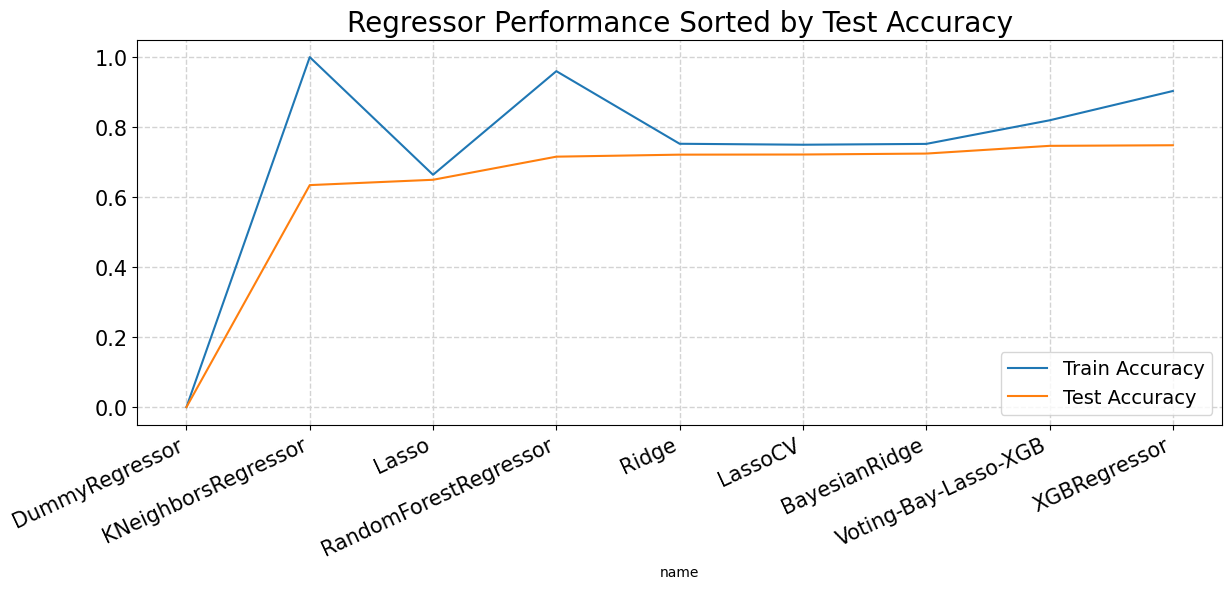

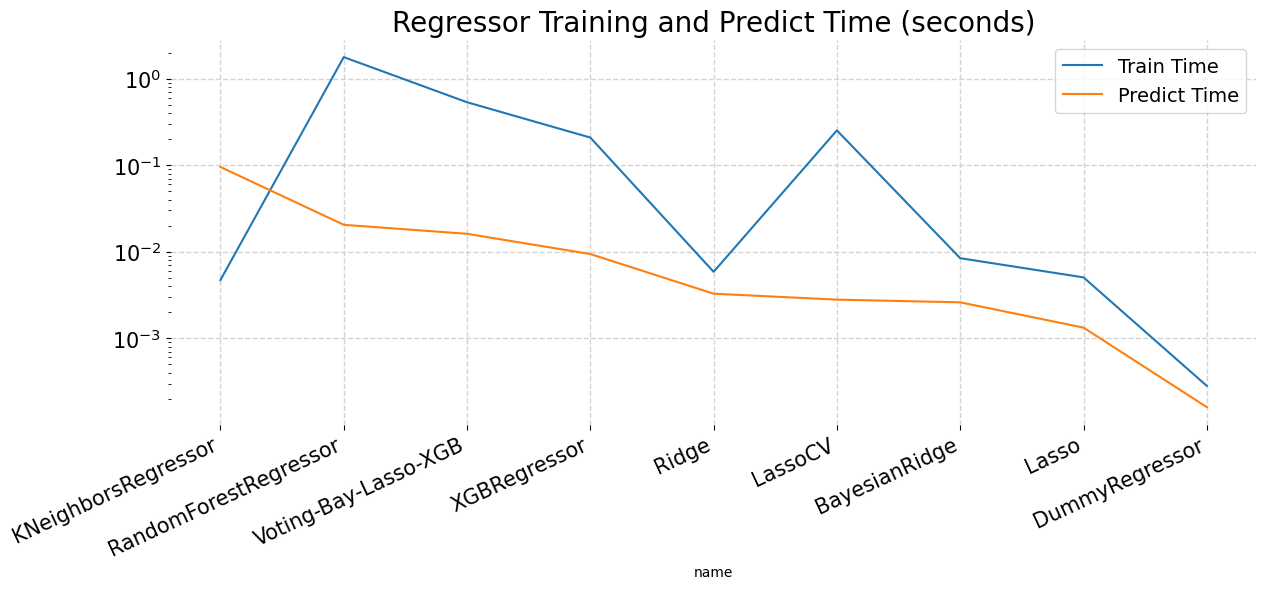

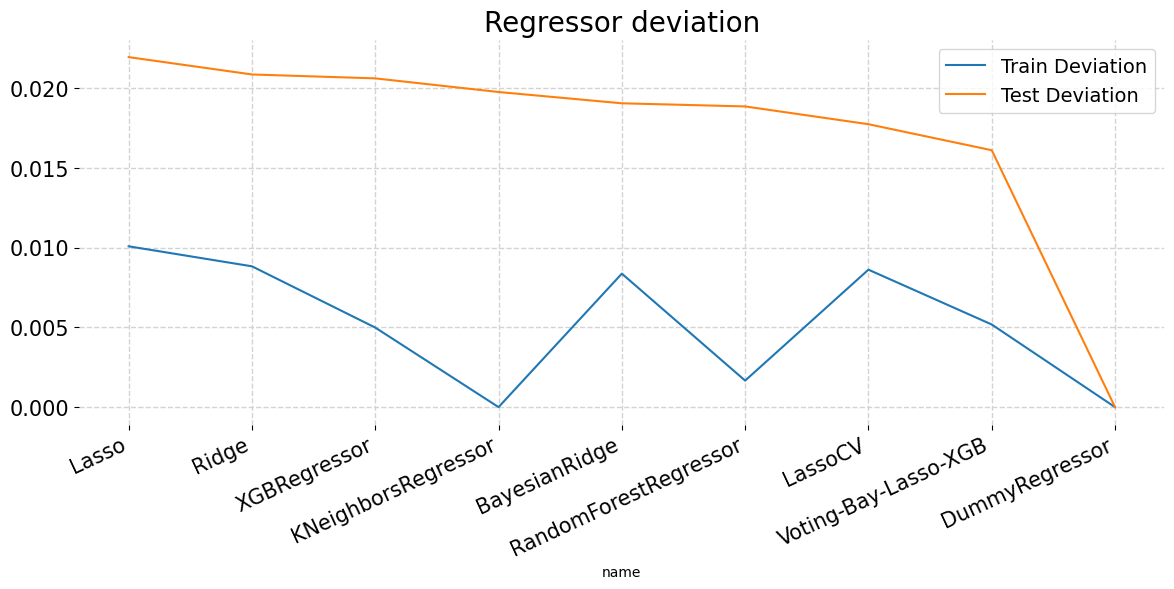

In [47]:
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

trained_models = [] #  keep track of all details for models we train
def train_model(model, data, labels): 
    X = data
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    start_time = time.time()
    trained_model = model["clf"].fit(X_train, y_train)
    train_time = time.time() - start_time

    #mask_non_res = X_test[['BuildingType_Nonresidential', 'BuildingType_Nonresidential cos', 'BuildingType_Nonresidential wa']].sum(axis=1) == 1
    #X_test = X_test.loc[mask_non_res]
    #y_test = y_test.loc[mask_non_res]

    start_time = time.time()
    y_pred = trained_model.predict(X_test)
    predict_time = time.time() - start_time
    
    test_score = metrics.r2_score(y_test, y_pred)
    test_score = max(test_score, 0)
    
    y_pred = trained_model.predict(X_train)
    train_score = metrics.r2_score(y_train, y_pred)
    train_score = max(train_score, 0)
    
    model_details = {"name": model["name"], "test_accuracy": test_score, "train_accuracy": train_score, "train_time": train_time, "predict_time": predict_time}
    return model_details

models = [
          {"name": "Dummy Regressor", "clf": dummy.DummyRegressor()},
          {"name": "KNN", "clf": KNeighborsRegressor(n_neighbors=10, weights='distance')},
          {"name": "LassoCV", "clf": LassoCV(cv=50)}, 
          {"name": "Lasso", "clf": Lasso(alpha=0.1)},
          {"name": "RandomForestRegressor", "clf": RandomForestRegressor(max_depth=75)},
          {"name": "Ridge", "clf": Ridge(alpha=0.89)}, 
          {"name": "LinearRegression", "clf": LinearRegression()}, 
          {"name": "BayesianRidge", "clf": BayesianRidge()},
          {"name": "Best Model", "clf": best_model}]

for model in list_models*50:
    model_details = train_model(model, data_X[col_num], data_Y[TARGET]) 
    trained_models.append(model_details)


    
# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models).groupby('name').mean()
model_df.sort_values("test_accuracy", inplace=True)
print(model_df["test_accuracy"])
ax = model_df[["train_accuracy","test_accuracy"]].plot(kind="line", figsize=(14,5), title="Regressor Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
ax.title.set_size(20)
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
#plt.xticks(rotation=90)

model_df.sort_values("predict_time", inplace=True, ascending=False)
ax= model_df[["train_time", "predict_time"]].plot(kind="line", figsize=(14,5), grid=True, title="Regressor Training and Predict Time (seconds)", logy=True)
ax.title.set_size(20)
ax.legend(["Train Time", "Predict Time"])
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
plt.box(False)  


model_df = pd.DataFrame(trained_models).groupby('name').std()
model_df.sort_values("test_accuracy", inplace=True, ascending=False)
ax= model_df[["train_accuracy","test_accuracy"]].plot(kind="line", figsize=(14,5), grid=True, title="Regressor deviation")
ax.title.set_size(20)
ax.legend(["Train Deviation", "Test Deviation"])
ax.set_xticks(range(len(model_df)), model_df.index.to_list(), rotation=25, ha='right')
plt.box(False) 

In [24]:
import shap

In [25]:
shap.initjs()

In [26]:
shap_model = BayesianRidge(alpha_init=1, lambda_init=0.1)#LassoCV(cv=5)
shap_model.fit(data_X[col_num], data_Y[TARGET])

explainer = shap.Explainer(shap_model, data_X[col_num], feature_names=col_num)
shap_values = explainer.shap_values(data_X[col_num])

In [27]:
#shap_model = XGBRegressor().fit(data_X[col_num], data_Y[TARGET])

In [28]:
#explainer = shap.Explainer(shap_model, feature_names=col_num)
#shap_values = explainer.shap_values(data_X[col_num])

In [29]:
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=col_num)

In [30]:
#shap.plots.waterfall(shap_values[0])

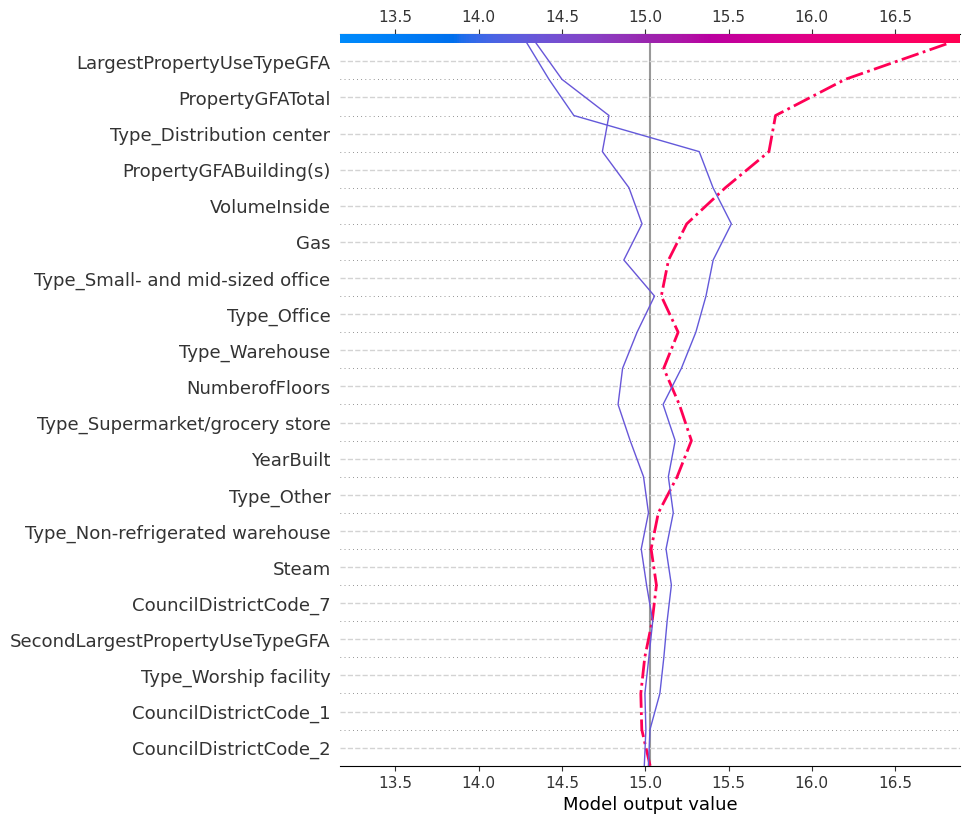

In [31]:
shap.decision_plot(explainer.expected_value, shap_values[0:3], col_num, highlight=0)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


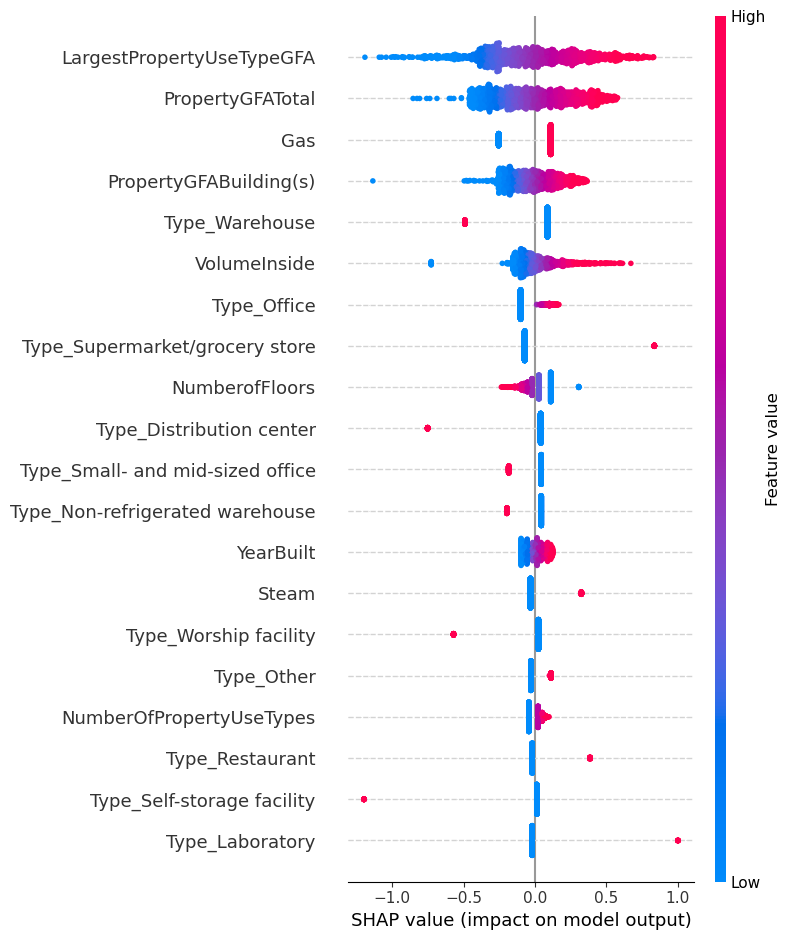

In [32]:
shap.summary_plot(shap_values, data_X[col_num], max_display=20)

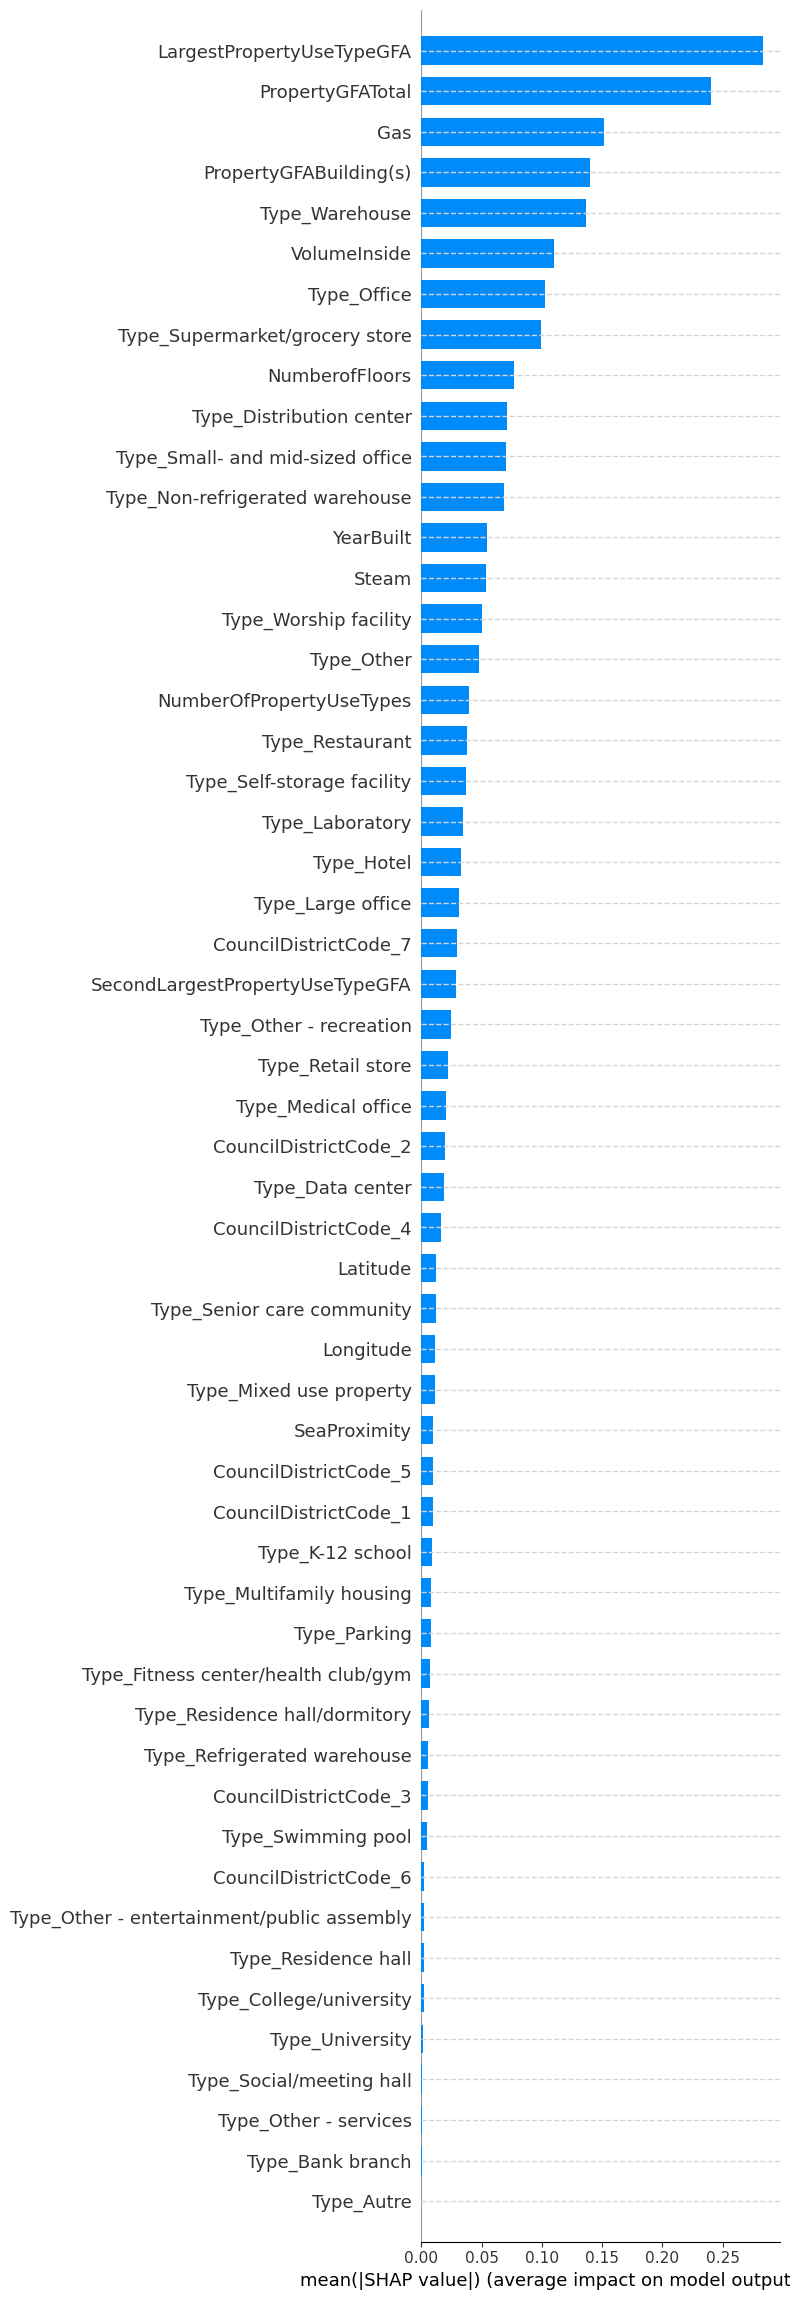

In [33]:
shap.summary_plot(shap_values, data_X[col_num], plot_type="bar", max_display=100)

In [34]:
output = 'Energy_Y'
algo = 'bay'
etoile = 'etoile' if avec_etoile == 1 else ''

In [35]:
y_hist = pd.DataFrame(columns=['Test', 'Predict'])

In [36]:
kf = KFold(n_splits=8)

for train, test in kf.split(data_X):
    X_train, y_train = data_X[col_num].iloc[train], data_Y[output].iloc[train]
    X_test, y_test = data_X[col_num].iloc[test], data_Y[output].iloc[test]
    
    model = BayesianRidge(alpha_init=1, lambda_init=0.1)
    if algo == 'XGB':
        model = XGBRegressor()
    model.fit(X_train, y_train)
    y_predict = pd.Series(model.predict(X_test), index=y_test.index)
    
    y_hist_tmp = pd.concat([y_test, y_predict], axis=1)
    y_hist_tmp.columns=['Test', 'Predict']
    
    y_hist = pd.concat([y_hist, y_hist_tmp])

In [37]:
y_hist['Diff'] = np.log(np.abs(np.exp(y_hist['Test'])-np.exp(y_hist['Predict'])))

In [38]:
y_hist

,Test,Predict,Diff
3124,16.435108,16.811475,15.651997
2593,14.566835,14.380850,12.793194
2918,12.834027,14.304247,14.043044
2962,15.958160,15.026278,15.457595
61,15.125491,15.845923,15.179336
...,...,...,...
3187,17.871883,16.829152,17.437261
2078,14.561660,14.589076,10.978764
456,15.282506,16.326136,15.892002
1456,15.548153,15.532990,11.351660


In [39]:
import seaborn as sns

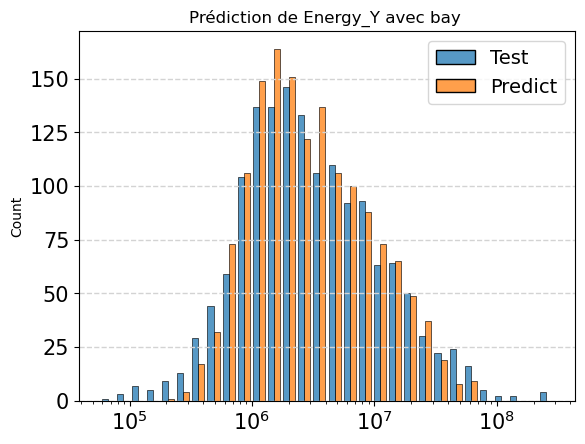

In [40]:
ax = sns.histplot(np.exp(y_hist[['Test', 'Predict']]), multiple="dodge", shrink=.8, log_scale=(True, False), bins=30)
ax.set(title="Prédiction de {} avec {} {}".format(output, algo, 'et Etoile' if etoile != '' else etoile))

fig = ax.get_figure()
fig.savefig("./data/graph/predict_{}_{}_{}.png".format(output, algo, etoile)) 

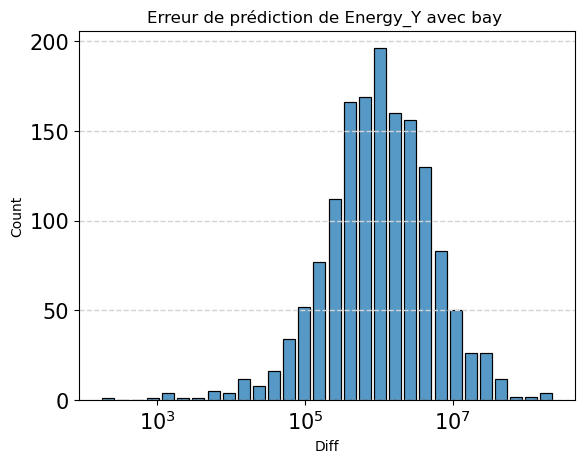

In [41]:
ax = sns.histplot(np.exp(y_hist['Diff']), shrink=.8, log_scale=(True, False), bins=30)
ax.set(title="Erreur de prédiction de {} avec {} {}".format(output, algo, 'et Etoile' if etoile != '' else etoile))

fig = ax.get_figure()
fig.savefig("./data/graph/erreur_{}_{}_{}.png".format(output, algo, etoile)) 

<AxesSubplot: xlabel='Test', ylabel='Predict'>

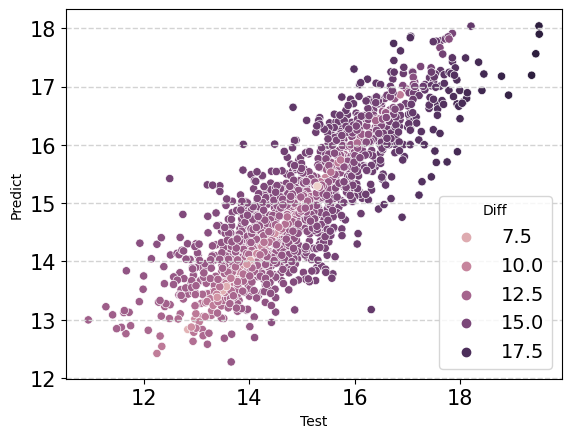

In [42]:
sns.scatterplot(y_hist, x='Test', y='Predict', hue='Diff')

In [43]:
annee_tranform = [(i, i*0.0334408 - 2.2) for i in range(0, 200, 5)]

In [44]:
model = BayesianRidge(alpha_init=1, lambda_init=0.1)
model.fit(data_X[col_num], data_Y['CO2_Y'])

BayesianRidge(alpha_init=1, lambda_init=0.1)

In [45]:
data_X_modif = data_X.loc[[1], col_num]

In [46]:
data_X.loc[[1], 'Age']

KeyError: 'Age'

In [ ]:
for i, i_pt in annee_tranform:
    data_X_modif_tmp = data_X_modif.copy()
    data_X_modif_tmp['Age'] = i_pt
    print(i, np.exp(model.predict(data_X_modif_tmp)[0]))

In [ ]:
np.exp(data_Y.loc[[1]])